# Align two MERFISH brain sections using modified LDDMM with automated landmarks on cell density and gene exp.
#### Version: Using automated landmark points. 

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)

In [1]:
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad 
import landmark as lm 
import STalign
# from STalign import STalign
dir(STalign)

/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/anndata/_core/anndata.py:22: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.4)
  from scipy import sparse
/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (None)/charset_normalizer (3.4.4) doesn't match a supported version!
  warnings.warn(


['LDDMM',
 'LDDMM_3D_to_slice',
 'L_T_from_points',
 'Line2D',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze3Dalign',
 'build_transform',
 'build_transform3D',
 'calculate_tre',
 'clip',
 'cm',
 'copy',
 'defaultdict',
 'download_aba_image_labels',
 'download_aba_ontology',
 'exists',
 'extent_from_x',
 'glob',
 'go',
 'grid_sample',
 'interp',
 'interp3D',
 'join',
 'make_scree',
 'makedirs',
 'normalize',
 'np',
 'nrrd',
 'os',
 'pd',
 'plot_brain_regions',
 'plot_subset_brain_regions',
 'plt',
 'px',
 'rasterize',
 'rasterizePCA',
 'rasterize_with_signal',
 'requests',
 'saveRasters',
 'split',
 'splitext',
 'sys',
 'to_A',
 'to_A_3D',
 'torch',
 'tornado',
 'transform_image_source_to_target',
 'transform_image_source_with_A',
 'transform_image_target_to_source',
 'transform_points_source_to_target',
 'transform_points_target_to_source',
 'v_to_phii',
 'v_to_phii_3D']

In [13]:
def normalize(arr, t_min=0, t_max=1):
    """Linearly normalizes an array between two specifed values.
    
    Parameters
    ----------
    arr : numpy array
        array to be normalized
    t_min : int or float
        Lower bound of normalization range
    t_max : int or float
        Upper bound of normalization range
    
    Returns
    -------
    norm_arr : numpy array
        1D array with normalized arr values
        
    """
    
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    min_ = np.min(arr)
    if diff_arr != 0:
        norm_arr = ((arr - min_)/diff_arr * diff) + t_min
    else:
        norm_arr = np.zeros(arr.shape)
    
    return norm_arr


def rasterize(x, y, g=np.ones(1), dx=15, blur=1.5, expand=1.2, draw=0, wavelet_magnitude=False,use_windowing=True):
    ''' Rasterize a spatial transcriptomics dataset into a density image
    
    Paramters
    ---------
    x : numpy array of length N
        x location of cells
    y : numpy array of length N
        y location of cells
    g : numpy array of length N
        RNA count of cells
        If not given, density image is created
    dx : float
        Pixel size to rasterize data (default 30.0, in same units as x and y)
    blur : float or list of floats
        Standard deviation of Gaussian interpolation kernel.  Units are in 
        number of pixels.  Can be aUse a list to do multi scale.
    expand : float
        Factor to expand sampled area beyond cells. Defaults to 1.1.
    draw : int
        If True, draw a figure every draw points return its handle. Defaults to False (0).
    wavelet_magnitude : bool
        If True, take the absolute value of difference between scales for raster images.
        When using this option blur should be sorted from greatest to least.
    
        
    Returns
    -------
    X  : numpy array
        Locations of pixels along the x axis
    Y  : numpy array
        Locations of pixels along the y axis
    M : numpy array
        A rasterized image with len(blur) channels along the first axis
    fig : matplotlib figure handle
        If draw=True, returns a figure handle to the drawn figure.
        
    Raises
    ------    
    Exception 
        If wavelet_magnitude is set to true but blur is not sorted from greatest to least.
        
        
    
    Examples
    --------
    Rasterize a dataset at 30 micron pixel size, with three kernels.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000)
    
    Rasterize a dataset at 30 micron pixel size, with three kernels, using difference between scales.
    
    >>> X,Y,M,fig = tools.rasterize(x,y,dx=30.0,blur=[2.0,1.0,0.5],draw=10000, wavelet_magnitude=True)
        
        
    '''
    
    # set blur to a list
    if not isinstance(blur,list):
        blur = [blur]
    nb = len(blur)
    blur = np.array(blur)
    n = len(x)
    maxblur = np.max(blur) # for windowing
    
    
    
    if wavelet_magnitude and np.any(blur != np.sort(blur)[::-1]):
        raise Exception('When using wavelet magnitude, blurs must be sorted from greatest to least')
    
    minx = np.min(x)
    maxx = np.max(x)
    miny = np.min(y)
    maxy = np.max(y)
    minx,maxx = (minx+maxx)/2.0 - (maxx-minx)/2.0*expand, (minx+maxx)/2.0 + (maxx-minx)/2.0*expand
    miny,maxy = (miny+maxy)/2.0 - (maxy-miny)/2.0*expand, (miny+maxy)/2.0 + (maxy-miny)/2.0*expand
    X_ = np.arange(minx,maxx,dx)
    Y_ = np.arange(miny,maxy,dx)
    
    X = np.stack(np.meshgrid(X_,Y_)) # note this is xy order, not row col order

    W = np.zeros((X.shape[1],X.shape[2],nb))

    
    if draw: fig,ax = plt.subplots()
    count = 0
    
    g = np.resize(g,x.size)
    if(not (g==1.0).all()):
        g = normalize(g)
    #if np.sum(g) == 0:
    #    print('no gene exp')
    #    return X,Y,W, None
    for x_,y_,g_ in zip(x,y,g):
        # to speed things up I should index
        # to do this I'd have to find row and column indices
        #col = np.round((x_ - X_[0])/dx).astype(int)
        #row = np.round((y_ - X_[1])/dx).astype(int)
        #row0 = np.floor(row-blur*3).astype(int)
        #row1 = np.ceil(row+blur*3).astype(int)        
        #rows = np.arange(row0,row1+1)
        

        # this is incrementing one pixel at a time, it is way way faster, 
        # but doesn't use a kernel
        # I[c_,row,col] += 1.0
        # W[row,col] += 1.0
        if not use_windowing: # legacy version
            k = np.exp( - ( (X[0][...,None] - x_)**2 + (X[1][...,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)    
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]

            W += k
        else: # use a small window
            r = int(np.ceil(maxblur*4))
            col = np.round((x_ - X_[0])/dx).astype(int)
            row = np.round((y_ - Y_[0])/dx).astype(int)
            
            row0 = np.floor(row-r).astype(int)
            row1 = np.ceil(row+r).astype(int)                    
            col0 = np.floor(col-r).astype(int)
            col1 = np.ceil(col+r).astype(int)
            
            # we need boundary conditions
            row0 = np.minimum(np.maximum(row0,0),W.shape[0]-1)
            row1 = np.minimum(np.maximum(row1,0),W.shape[0]-1)
            col0 = np.minimum(np.maximum(col0,0),W.shape[1]-1)
            col1 = np.minimum(np.maximum(col1,0),W.shape[1]-1)
            
           
            k =  np.exp( - ( (X[0][row0:row1+1,col0:col1+1,None] - x_)**2 + (X[1][row0:row1+1,col0:col1+1,None] - y_)**2 )/(2.0*(dx*blur*2)**2)  )
            if np.sum(k,axis=(0,1)) != 0:
                k /= np.sum(k,axis=(0,1),keepdims=True)  
            else:
                k=k
            k *= g_
            if wavelet_magnitude:
                for i in reversed(range(nb)):
                    if i == 0:
                        continue
                    k[...,i] = k[...,i] - k[...,i-1]
            W[row0:row1+1,col0:col1+1,:] += k #range of voxels -oka
            
        
            
        

        if draw:
            if not count%draw or count==(x.shape[0]-1):
                print(f'{count} of {x.shape[0]}')

                ax.cla()
                toshow = W-np.min(W,axis=(0,1),keepdims=True)
                toshow = toshow / np.max(toshow,axis=(0,1),keepdims=True)
                
                if nb >= 3:
                    toshow = toshow[...,:3]
                elif nb == 2:
                    toshow = toshow[...,[0,1,0]]
                elif nb == 1:
                    toshow = toshow[...,[0,0,0]]
                
                ax.imshow(np.abs(toshow))
                fig.canvas.draw()

        count += 1
    W = np.abs(W)
    # we will permute so channels are on first axis
    W = W.transpose((-1,0,1))
    extent = (X_[0],X_[-1],Y_[0],Y_[-1])
    
    # rename
    X = X_
    Y = Y_
    if draw:
        output = X,Y,W,fig
    else:
        output = X,Y,W
    return output

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T
    
import torch

def to_A(L,T):
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def extent_from_x(xJ): #bounds for image to plot - ok
    dJ = [x[1]-x[0] for x in xJ] #step size between pixels along the axes - but is this difference between x and y?
    extentJ = ((xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    
    return extentJ

def clip(I):

    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic

def interp(x,I,phii,**kwargs):
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]

In [14]:
def rasterizeByGene(x, y, G, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True):
    nrows=0
    ncols=0
    
    for i in range(G.shape[1]):
        g = np.array(G.iloc[:,i])
        
        XI,YI,I = rasterize(x,y,g=g,dx=dx,blur=blur,expand =expand)
        
        if(i==0):
            # dimensions
            nrows=YI.size
            ncols=XI.size
            X = np.empty([G.shape[1], nrows, ncols])
            Y = np.empty([G.shape[1], nrows*ncols])
        
        # centers data
        X[i] = np.array(I)
        I_ = I.ravel()
        meanI = np.mean(I_)
        I_ -= meanI
        Y[i] = I_
        
        if(i % 10 == 0):
            print(f"{i} out of {G.shape[1]} genes rasterized.")

    
    return X, Y, XI, YI

In [32]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/')

# Load target data (S2R3)
source_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
source_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

# Load source data (S2R2) 
target_metadata = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
target_gexp = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)

Text(0.5, 1.0, 'Overlay of Source and Target MERFISH ST Data')

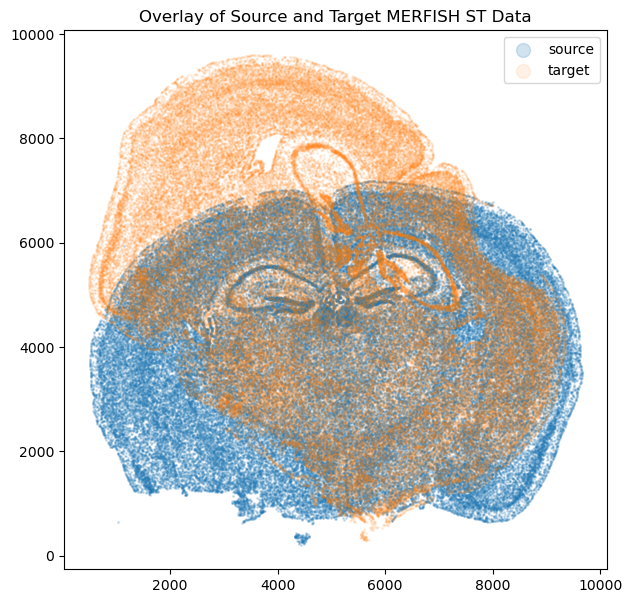

In [33]:
# STalign only needs cell centroid info, pull this 
xI = np.array(source_metadata['center_x'])
yI = np.array(source_metadata['center_y'])

xJ = np.array(target_metadata['center_x'])
yJ = np.array(target_metadata['center_y'])

# Plot 
fig,ax=plt.subplots(figsize=(7,7))
ax.scatter(xI, yI, s=1,alpha=0.2, label='source')
ax.scatter(xJ, yJ, s=1,alpha=0.1, label='target')
ax.legend(markerscale=10)
plt.title("Overlay of Source and Target MERFISH ST Data")

In [34]:
source_ad = ad.AnnData(np.array(source_gexp))
source_ad.var_names = np.array(source_gexp.columns)
source_ad.obs_names = source_gexp.index
source_ad.obsm['spatial'] = np.array([[xI[i], yI[i]] for i in range(len(xI))])

target_ad = ad.AnnData(np.array(target_gexp))
target_ad.var_names = np.array(target_gexp.columns) 
target_ad.obs_names = target_gexp.index 
target_ad.obsm['spatial'] = np.array([[xJ[i], yJ[i]] for i in range(len(xJ))])

In [35]:
#((85958, 649), (84172, 649))
source_ad.shape, target_ad.shape

((85958, 649), (84172, 649))

In [36]:
sc.pp.filter_cells(target_ad, min_genes=100)
sc.pp.filter_genes(target_ad, min_cells=3)
sc.pp.filter_cells(source_ad, min_genes=100)
sc.pp.filter_genes(source_ad, min_cells=3)

source_ad.X = source_ad.X.astype(np.float64)
target_ad.X = target_ad.X.astype(np.float64)

sc.pp.normalize_total(source_ad, target_sum=1e4)
sc.pp.log1p(source_ad)

sc.pp.normalize_total(target_ad, target_sum=1e4)
sc.pp.log1p(target_ad)

# calculate highly variable genes (HVGs)
sc.pp.highly_variable_genes(source_ad)
sc.pp.highly_variable_genes(target_ad)

# extract top 500 variable genes for source and target 
genes_tI = np.array(source_ad.var['highly_variable'][source_ad.var['highly_variable']==True][0:500].index.values)
genes_tJ = np.array(target_ad.var['highly_variable'][target_ad.var['highly_variable']==True][0:500].index.values)

# find intersecting highly variable genes (85 total) 
genes_int = np.intersect1d(genes_tI, genes_tJ)

dfI = pd.DataFrame(source_ad.X, columns=source_ad.var.index)
dfJ = pd.DataFrame(target_ad.X, columns=target_ad.var.index)

indicesI = [index for index, value in enumerate(source_ad.var.index) if value in genes_int]
indicesJ = [index for index, value in enumerate(target_ad.var.index) if value in genes_int]

# subsetted dataframe of gene exp data (cells by genes) 
GI = dfI.iloc[:,indicesI]
GJ = dfJ.iloc[:,indicesJ]

# get list of length 2 for x and y coords 
list_I = [source_ad.obsm['spatial'][:,0],source_ad.obsm['spatial'][:,1]]
list_J = [target_ad.obsm['spatial'][:,0],target_ad.obsm['spatial'][:,1]]

In [37]:
# Rasterize all genes 
XgI, Y, XI, YI = rasterizeByGene(list_I[0], # x coordinates of cells in Dataset I 
                                   list_I[1], # y coordinates of cells in Dataset I
                                   GI, # cell by gene matrix for Dataset I 
                                   dx=15, 
                                   blur=1.5)

0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.


In [38]:
XgJ, Y, XJ, YJ = rasterizeByGene(list_J[0], 
                                   list_J[1], 
                                   GJ, 
                                   dx=15, 
                                   blur=1.5)

0 out of 85 genes rasterized.
10 out of 85 genes rasterized.
20 out of 85 genes rasterized.
30 out of 85 genes rasterized.
40 out of 85 genes rasterized.
50 out of 85 genes rasterized.
60 out of 85 genes rasterized.
70 out of 85 genes rasterized.
80 out of 85 genes rasterized.


In [39]:
X, Y, XctI = rasterize(list_I[0], list_I[1]) # Xct cell type density images 
X, Y, XctJ = rasterize(list_J[0], list_J[1])

In [40]:
gene_candidates = [17, 27, 33, 37, 42, 44, 49, 51, 54, 58, 75, 80]

In [41]:
len(gene_candidates)

12

Text(0.5, 1.0, 'Rasterized Target Image, J')

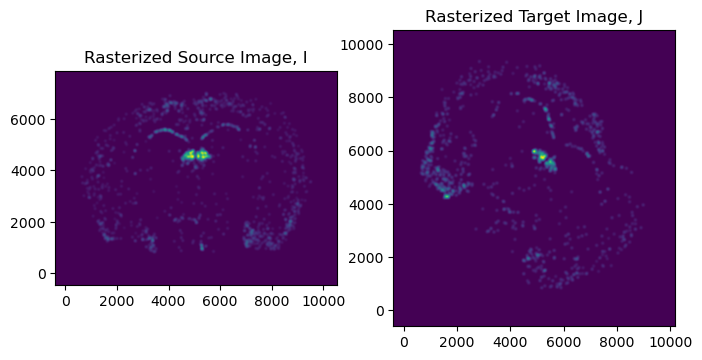

In [42]:
# plot rasterized images next to each other 
# get extent of images 
extentI = extent_from_x((YI,XI))
extentJ = extent_from_x((YJ,XJ))

# plot rasterized images 
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(XgI[0], extent=extentI)
ax[1].imshow(XgJ[0], extent=extentJ)
# ax[0].imshow(XctI[0], extent=extentI)
# ax[1].imshow(XctJ[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")

In [43]:
GJ.columns == GI.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

Selecting 20 landmark points at threshold 0.01...
Returning sampled points...
Selecting 20 landmark points at threshold 0.01...
Returning sampled points...


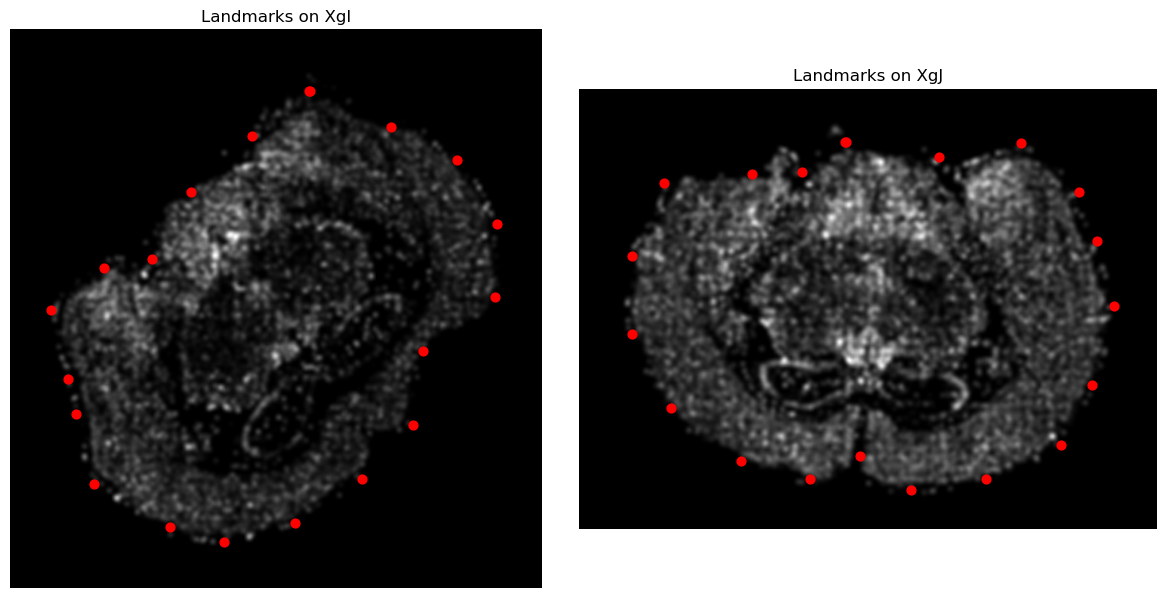

In [24]:
source_pts = lm.get_edge_landmarks(XgI, n_points=20, threshold=0.01)
target_pts = lm.get_edge_landmarks(XgJ, n_points=20, threshold=0.01)

#print(source_pts.shape, target_pts.shape)
lm.visualize_points(XgI, XgJ, source_pts, target_pts)

In [44]:
source_pts, target_pts

(array([[396,  81],
        [320, 141],
        [239, 215],
        [188, 304],
        [124, 316],
        [ 54, 372],
        [ 76, 463],
        [ 87, 510],
        [111, 603],
        [212, 660],
        [283, 679],
        [378, 654],
        [466, 596],
        [534, 524],
        [547, 426],
        [643, 355],
        [645, 258],
        [593, 173],
        [505, 129],
        [397,  81]], dtype=int32),
 array([[335,  67],
        [281, 105],
        [217, 107],
        [106, 118],
        [ 66, 210],
        [ 66, 309],
        [115, 402],
        [203, 469],
        [291, 492],
        [354, 463],
        [418, 506],
        [513, 492],
        [607, 449],
        [646, 373],
        [674, 273],
        [653, 192],
        [630, 129],
        [557,  68],
        [454,  85],
        [336,  67]], dtype=int32))

In [45]:
# Compute L and T
L, T = L_T_from_points(source_pts, target_pts)
print("Linear matrix L:\n", L)
print("Translation vector T:\n", T)

Linear matrix L:
 [[ 1.0654989   0.41636408]
 [-0.11621665  0.78378619]]
Translation vector T:
 [-143.03233423   12.8146476 ]


In [46]:
A = to_A(torch.tensor(L),torch.tensor(T))

In [47]:
XctI = (XctI - np.min(XctI))/(np.max(XctI)-np.min(XctI))
XctJ = (XctJ - np.min(XctJ))/(np.max(XctJ)-np.min(XctJ))

XgI = (XgI - np.min(XgI))/(np.max(XgI)-np.min(XgI))
XgJ = (XgJ - np.min(XgJ))/(np.max(XgJ)-np.min(XgJ))

In [48]:
XctI.shape, XctJ.shape, XgI.shape, XgJ.shape

((1, 555, 729), (1, 741, 705), (85, 555, 729), (85, 741, 705))

In [49]:
def LDDMM(xI,I,xJ,J,Ig, Jg, pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaMg=1.0, sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
 
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    Jg = torch.tensor(Jg,device=device,dtype=dtype)
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand # WHY DO IT THIS WAY??
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)] # "a" determines step size of velocity field
        XV = torch.stack(torch.meshgrid(xv),-1) #creating a meshgrid to apply transformation to all points in a grid (creating the 'field' in velocity field)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True) # why does XW have a shape of 3 (aren't there only x and y points? 2D)
        #velocity field start out as a zero vector field - how does it get updated? 
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv) #for plotting purposes
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype) #step in between each set of points
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)] # 5 dimensions of grid of XV/dv - should be similar to XV but not a meshgrid, just points along each axis
    extentF = extent_from_x(fv) #plotting
    FV = torch.stack(torch.meshgrid(fv),-1) # would this not just be the same as XV? print out both and compare 
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0) #smoothing kernel? what is this?

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    

    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,5)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        #print(Xs.shape)
        # transform image
        #AI = interp(xI,I.swapaxes(1,2),Xs.permute(2,1,0),padding_mode="border")
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")
        AIg = interp(xI,Ig,Xs.permute(2,0,1),padding_mode="border")
        #AI = AI.permute(0,2,1)
        #print(AI.shape)
        #print(J.shape)
        if it == 0:
            AI_orig = AIg.clone().detach()
        # objective function
        EMg = torch.sum((AIg - Jg)**2*WM)/2.0/sigmaMg**2
        
        EM = torch.sum((AI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER + EMg
        tosave = [E.item(), EM.item(), ER.item(), EMg.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.9




        # draw
        if not it%10:
            AI_plt = AIg
            J_plt = Jg
            #print(AI.shape)
            if AI.shape[0]>=1:
                AI_plt = torch.mean(AIg, 0)
                AI_plt = torch.unsqueeze(AI_plt, 0)
                AI_orig = torch.mean(AI_orig, 0)
                AI_orig = torch.unsqueeze(AI_orig, 0)
                J_plt = torch.mean(Jg, 0)
                J_plt = torch.unsqueeze(J_plt, 0)
            #print(AI_plt.shape)
            ax[0].cla()
            ax[0].imshow(   ((AI_orig-torch.amin(AI_orig,(1,2))[...,None,None])/(torch.amax(AI_orig,(1,2))-torch.amin(AI_orig,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()
            ax[1].imshow(   ((AI_plt-torch.amin(AI_plt,(1,2))[...,None,None])/(torch.amax(AI_plt,(1,2))-torch.amin(AI_plt,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('space tformed source')
            
            ax[4].cla()
            ax[4].imshow(clip( (AI_plt - J_plt)/(torch.max(Jg).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[4].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[4].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[4].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J_plt.permute(1,2,0).cpu()/torch.max(Jg).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            

            Esave_array = np.array(Esave)  # shape: (niter_done, n_components)

            # Compute per-iteration delta
            delta = np.diff(Esave_array, axis=0)  # shape: (niter_done-1, n_components)
            delta = np.vstack([np.zeros((1,Esave_array.shape[1])), delta])  # prepend 0 for first iteration
            
            labels = ['E', 'EM', 'ER', 'EMg', 'EP']
            
            for i in range(len(labels)):
                axE[i].cla()
                axE[i].plot([e[i] for e in Esave], label=f'{labels[i]}')
                axE[i].set_yscale('log')
                
                # Annotate the last delta on the plot
                axE[i].text(0.95, 0.95, f'Δ={delta[-1,i]:.3e}', 
                             transform=axE[i].transAxes,
                             horizontalalignment='right', verticalalignment='top',
                             fontsize=9, color='red')
                
                axE[i].legend([labels[i]])

            fig.canvas.draw()
            figE.canvas.draw()
    # Compute delta energy per component
    Esave_array = np.array(Esave)
    deltaE = np.diff(Esave_array, axis=0)
    deltaE = np.vstack([np.zeros((1,Esave_array.shape[1])), deltaE])
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach(),
        "Esave": Esave_array,
        "deltaE": deltaE
    }

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_5239/1363260076.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_5239/1363260076.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_5239/1363260076.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor

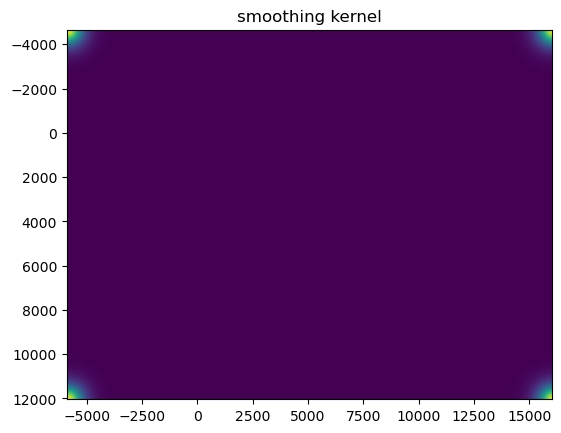

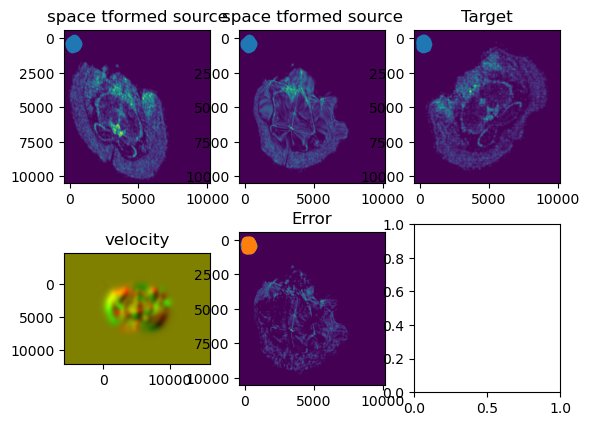

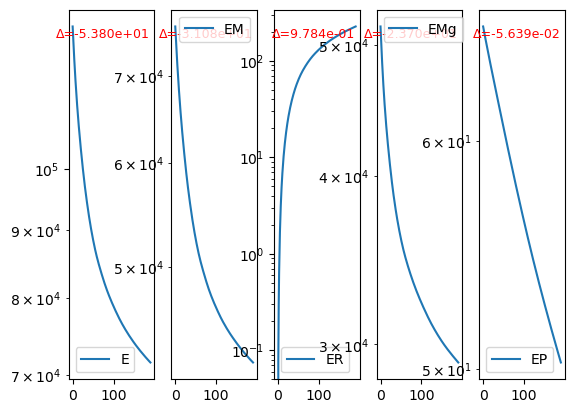

In [51]:
params = {
    'niter': 200,
    'a': 200,
    'pointsI': source_pts,
    'pointsJ': target_pts,
    'sigmaM': 0.25,
    'sigmaMg': 0.25,
    'A': A
}


# Selecting spatially distinct genes
out_cell_g = LDDMM(
    xI=[YI, XI], 
    xJ=[YJ, XJ], 
    I = XctI,
    Ig=XgI[gene_candidates, :, :],
    Jg=XgJ[gene_candidates, :, :],
    J = XctJ,
    **params
)

Text(0.5, 1.0, 'ER across 200 iterations with a = 200')

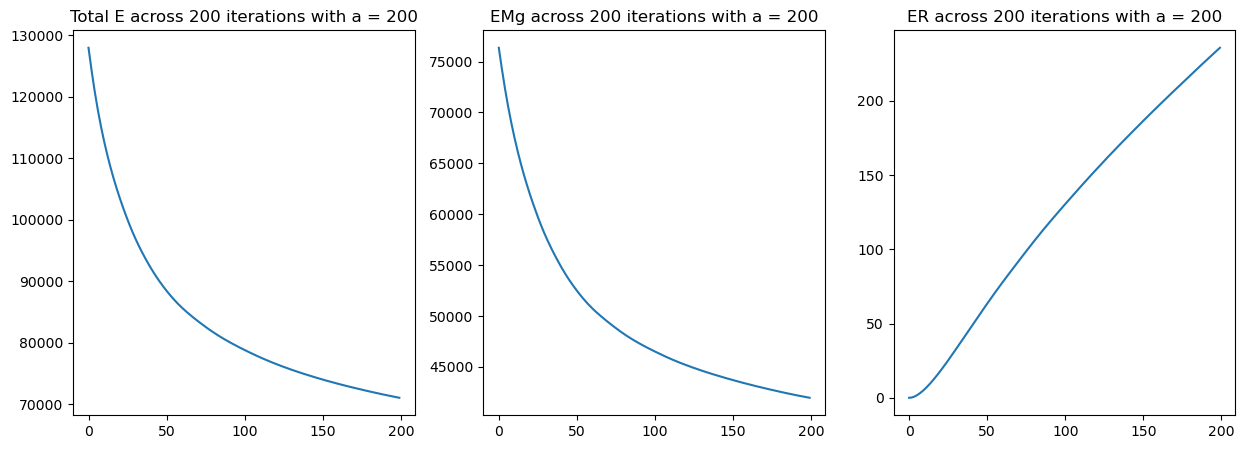

In [52]:
Esave = out_cell_g['Esave']
# Esave saves total, EMg, and ER 
n_iter = 200 
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(Esave[:,0]) 
ax[0].set_title(f"Total E across {n_iter} iterations with a = 200")
ax[1].plot(Esave[:,1]) 
ax[1].set_title(f"EMg across {n_iter} iterations with a = 200")
ax[2].plot(Esave[:,2]) 
ax[2].set_title(f"ER across {n_iter} iterations with a = 200")

In [ ]:
Esave_v1 = out_cell_g['Esave']
total_E_version1 = Esave_v1[:,0]
# delta-E from first to last 
delta_total_E_version1 = total_E_version1[0] - total_E_version1[-1] 
delta_total_E_version1, total_E_version1[-1]

(56841.839718114104, 71083.25261093547)

In [57]:
A = out_cell_g['A']
v = out_cell_g['v']
xv = out_cell_g['xv']

# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], axis=1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

Text(0.5, 1.0, 'LDDMM only gene expression')

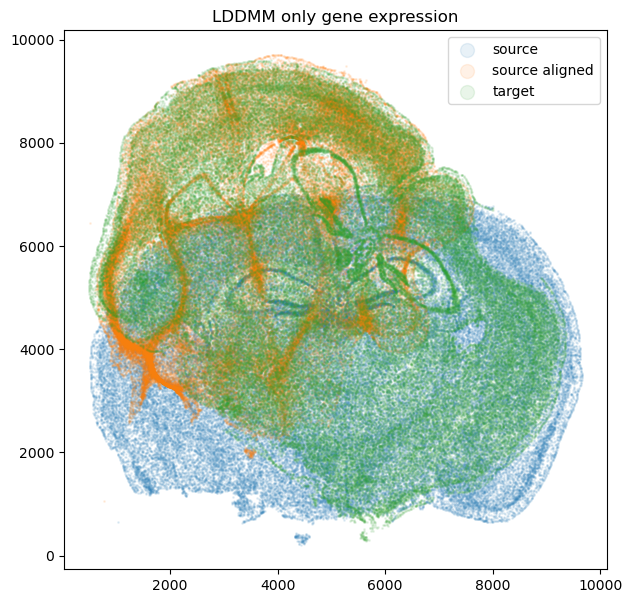

In [58]:
# plot results
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)
ax.set_title("LDDMM only gene expression")